In [9]:
import sys
sys.path.append('./models/')
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from data_loader import Dataset,Options
import models.unet_normals as unet
from tensorboardX import SummaryWriter
import OpenEXR, Imath

### Setup Options
Set the various parameters:
- dataroot: The folder where the training data is stored
- file_list: List of filenames of images for training
- batchSize: Batch size for model
- shuffle: If true, will shuffle the dataset
- phase: If 'train', then it's in training mode.
- num_epochs: Number of epochs to train the model for
- imsize: Dimensions of the image (square)
- num_classes: Num of classes in the output
- gpu: Which GPU device to use
- logs_path: The path where the log files (tensorboard) will be saved.

In [10]:
class OPT():
    def __init__(self):
        self.dataroot = './data/'
        self.file_list = './data/datalist'
        self.batchSize = 24
        self.shuffle = True
        self.phase = 'train'
        self.num_epochs = 1000
        self.imsize = 224
        self.num_classes = int(3)
        self.gpu = '0'
        self.logs_path = 'logs/exp2'

opt = OPT()

### Setup logging and dataloaders

In [11]:
###################### Options #############################
phase = opt.phase
device = torch.device("cuda:"+ opt.gpu if torch.cuda.is_available() else "cpu")

###################### TensorBoardX #############################
if os.path.exists(opt.logs_path):
    raise Exception('The folder \"{}\" already exists! Define a new log path or delete old contents.'.format(opt.logs_path))
    
writer = SummaryWriter(opt.logs_path, comment='create-graph')
graph_created = False

###################### DataLoader #############################
dataloader = Dataset(opt)


shuffling the dataset


### Create the model
We use a UNet model. The last few layers of this model are modified to return a 3 channel image, containing the x,y,z values of surface normal vectors.

In [12]:
###################### ModelBuilder #############################
model = unet.Unet(num_classes=opt.num_classes)
model = model.to(device)
model.train()

###################### Setup Optimazation #############################
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

###################### Loss fuction #############################
'''
@input: The 2 vectors whose cosine loss is to be calculated
The dimensions of the matrices are expected to be (batchSize, 3, imsize, imsize). 

@return: 
elementwise_mean: will return the sum of all losses divided by num of elements
none: The loss will be calculated to be of size (batchSize, imsize, imsize) containing cosine loss of each pixel
'''
def loss_fn(input_vec, target_vec, reduction='elementwise_mean'):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    loss_val = 1.0 - cos(input_vec, target_vec)
    if (reduction=='elementwise_mean'):
        return torch.mean(loss_val)
    elif (reduction=='none'):
        return loss_val
    else:
        raise Exception('Warning! The reduction is invalid. Please use \'elementwise_mean\' or \'none\''.format())


### Train the model


In [13]:
###################### Train Model #############################
# Calculate total iter_num
total_iter_num = 0

for epoch in range(opt.num_epochs):
    print('Epoch {}/{}'.format(epoch, opt.num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    running_loss = 0.0
    
    


    # Iterate over data.
    for i in range(int(dataloader.size()/opt.batchSize)):
        total_iter_num += 1
        
        # Get data
        inputs, labels =  dataloader.get_batch()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #ToDo: get labels into correct format
        
        ## Create Graph ##
        if graph_created == False:
            graph_created = True
            writer.add_graph(model, inputs, verbose=False)
        
        # Forward + Backward Prop
        optimizer.zero_grad()
        torch.set_grad_enabled(True)
        normal_vectors = model(inputs)
        normal_vectors_norm = nn.functional.normalize(normal_vectors, p=2, dim=1)
        
        loss = loss_fn(normal_vectors_norm, labels, reduction='elementwise_mean')
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item()
        writer.add_scalar('running_loss', running_loss, total_iter_num)
        writer.add_scalar('loss', loss.item(), total_iter_num)

    epoch_loss = running_loss / (dataloader.size()/opt.batchSize)
    print('{} Loss: {:.4f}'.format(phase, epoch_loss))
    
    # Save the model checkpoint
    directory = opt.logs_path+'/checkpoints/'
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    if (epoch % 10 == 0):
        filename = opt.logs_path + '/checkpoints/checkpoint-ep_{}-iter_{}.pth'.format(epoch,i)
        torch.save(model.state_dict(), filename)


Epoch 0/999
----------
train Loss: 0.6568
Epoch 1/999
----------
shuffling the dataset
train Loss: 0.1148
Epoch 2/999
----------
shuffling the dataset
train Loss: 0.1049
Epoch 3/999
----------
shuffling the dataset
train Loss: 0.0976
Epoch 4/999
----------
shuffling the dataset
train Loss: 0.1011
Epoch 5/999
----------
shuffling the dataset
train Loss: 0.0926
Epoch 6/999
----------
shuffling the dataset
train Loss: 0.0968
Epoch 7/999
----------
shuffling the dataset
train Loss: 0.0911
Epoch 8/999
----------
shuffling the dataset
train Loss: 0.1023
Epoch 9/999
----------
shuffling the dataset
train Loss: 0.0828
Epoch 10/999
----------
shuffling the dataset
train Loss: 0.0896
Epoch 11/999
----------
shuffling the dataset
train Loss: 0.1203
Epoch 12/999
----------
shuffling the dataset
train Loss: 0.0673
Epoch 13/999
----------
shuffling the dataset
train Loss: 0.1067
Epoch 14/999
----------
shuffling the dataset
train Loss: 0.1147
Epoch 15/999
----------
shuffling the dataset
train Loss:

shuffling the dataset
train Loss: 0.0877
Epoch 129/999
----------
shuffling the dataset
train Loss: 0.0806
Epoch 130/999
----------
shuffling the dataset
train Loss: 0.0969
Epoch 131/999
----------
shuffling the dataset
train Loss: 0.0937
Epoch 132/999
----------
shuffling the dataset
train Loss: 0.0882
Epoch 133/999
----------
shuffling the dataset
train Loss: 0.0860
Epoch 134/999
----------
shuffling the dataset
train Loss: 0.0798
Epoch 135/999
----------
shuffling the dataset
train Loss: 0.1046
Epoch 136/999
----------
shuffling the dataset
train Loss: 0.0955
Epoch 137/999
----------
shuffling the dataset
train Loss: 0.0766
Epoch 138/999
----------
shuffling the dataset
train Loss: 0.0959
Epoch 139/999
----------
shuffling the dataset
train Loss: 0.0684
Epoch 140/999
----------
shuffling the dataset
train Loss: 0.0887
Epoch 141/999
----------
shuffling the dataset
train Loss: 0.1006
Epoch 142/999
----------
shuffling the dataset
train Loss: 0.0850
Epoch 143/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0500
Epoch 255/999
----------
shuffling the dataset
train Loss: 0.0449
Epoch 256/999
----------
shuffling the dataset
train Loss: 0.0477
Epoch 257/999
----------
shuffling the dataset
train Loss: 0.0534
Epoch 258/999
----------
shuffling the dataset
train Loss: 0.0454
Epoch 259/999
----------
shuffling the dataset
train Loss: 0.0460
Epoch 260/999
----------
shuffling the dataset
train Loss: 0.0458
Epoch 261/999
----------
shuffling the dataset
train Loss: 0.0472
Epoch 262/999
----------
shuffling the dataset
train Loss: 0.0502
Epoch 263/999
----------
shuffling the dataset
train Loss: 0.0472
Epoch 264/999
----------
shuffling the dataset
train Loss: 0.0462
Epoch 265/999
----------
shuffling the dataset
train Loss: 0.0420
Epoch 266/999
----------
shuffling the dataset
train Loss: 0.0534
Epoch 267/999
----------
shuffling the dataset
train Loss: 0.0424
Epoch 268/999
----------
shuffling the dataset
train Loss: 0.0426
Epoch 269/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0309
Epoch 381/999
----------
shuffling the dataset
train Loss: 0.0371
Epoch 382/999
----------
shuffling the dataset
train Loss: 0.0307
Epoch 383/999
----------
shuffling the dataset
train Loss: 0.0303
Epoch 384/999
----------
shuffling the dataset
train Loss: 0.0336
Epoch 385/999
----------
shuffling the dataset
train Loss: 0.0292
Epoch 386/999
----------
shuffling the dataset
train Loss: 0.0298
Epoch 387/999
----------
shuffling the dataset
train Loss: 0.0314
Epoch 388/999
----------
shuffling the dataset
train Loss: 0.0283
Epoch 389/999
----------
shuffling the dataset
train Loss: 0.0300
Epoch 390/999
----------
shuffling the dataset
train Loss: 0.0279
Epoch 391/999
----------
shuffling the dataset
train Loss: 0.0297
Epoch 392/999
----------
shuffling the dataset
train Loss: 0.0280
Epoch 393/999
----------
shuffling the dataset
train Loss: 0.0282
Epoch 394/999
----------
shuffling the dataset
train Loss: 0.0296
Epoch 395/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0241
Epoch 507/999
----------
shuffling the dataset
train Loss: 0.0241
Epoch 508/999
----------
shuffling the dataset
train Loss: 0.0235
Epoch 509/999
----------
shuffling the dataset
train Loss: 0.0234
Epoch 510/999
----------
shuffling the dataset
train Loss: 0.0205
Epoch 511/999
----------
shuffling the dataset
train Loss: 0.0252
Epoch 512/999
----------
shuffling the dataset
train Loss: 0.0236
Epoch 513/999
----------
shuffling the dataset
train Loss: 0.0183
Epoch 514/999
----------
shuffling the dataset
train Loss: 0.0242
Epoch 515/999
----------
shuffling the dataset
train Loss: 0.0201
Epoch 516/999
----------
shuffling the dataset
train Loss: 0.0224
Epoch 517/999
----------
shuffling the dataset
train Loss: 0.0201
Epoch 518/999
----------
shuffling the dataset
train Loss: 0.0223
Epoch 519/999
----------
shuffling the dataset
train Loss: 0.0238
Epoch 520/999
----------
shuffling the dataset
train Loss: 0.0180
Epoch 521/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0198
Epoch 633/999
----------
shuffling the dataset
train Loss: 0.0165
Epoch 634/999
----------
shuffling the dataset
train Loss: 0.0214
Epoch 635/999
----------
shuffling the dataset
train Loss: 0.0159
Epoch 636/999
----------
shuffling the dataset
train Loss: 0.0207
Epoch 637/999
----------
shuffling the dataset
train Loss: 0.0191
Epoch 638/999
----------
shuffling the dataset
train Loss: 0.0163
Epoch 639/999
----------
shuffling the dataset
train Loss: 0.0175
Epoch 640/999
----------
shuffling the dataset
train Loss: 0.0164
Epoch 641/999
----------
shuffling the dataset
train Loss: 0.0180
Epoch 642/999
----------
shuffling the dataset
train Loss: 0.0171
Epoch 643/999
----------
shuffling the dataset
train Loss: 0.0171
Epoch 644/999
----------
shuffling the dataset
train Loss: 0.0168
Epoch 645/999
----------
shuffling the dataset
train Loss: 0.0156
Epoch 646/999
----------
shuffling the dataset
train Loss: 0.0171
Epoch 647/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0119
Epoch 759/999
----------
shuffling the dataset
train Loss: 0.0145
Epoch 760/999
----------
shuffling the dataset
train Loss: 0.0137
Epoch 761/999
----------
shuffling the dataset
train Loss: 0.0093
Epoch 762/999
----------
shuffling the dataset
train Loss: 0.0178
Epoch 763/999
----------
shuffling the dataset
train Loss: 0.0120
Epoch 764/999
----------
shuffling the dataset
train Loss: 0.0106
Epoch 765/999
----------
shuffling the dataset
train Loss: 0.0137
Epoch 766/999
----------
shuffling the dataset
train Loss: 0.0149
Epoch 767/999
----------
shuffling the dataset
train Loss: 0.0138
Epoch 768/999
----------
shuffling the dataset
train Loss: 0.0128
Epoch 769/999
----------
shuffling the dataset
train Loss: 0.0122
Epoch 770/999
----------
shuffling the dataset
train Loss: 0.0131
Epoch 771/999
----------
shuffling the dataset
train Loss: 0.0132
Epoch 772/999
----------
shuffling the dataset
train Loss: 0.0140
Epoch 773/999
----------
shuffling 

shuffling the dataset
train Loss: 0.0125
Epoch 885/999
----------
shuffling the dataset
train Loss: 0.0107
Epoch 886/999
----------
shuffling the dataset
train Loss: 0.0133
Epoch 887/999
----------
shuffling the dataset
train Loss: 0.0130
Epoch 888/999
----------
shuffling the dataset
train Loss: 0.0141
Epoch 889/999
----------
shuffling the dataset
train Loss: 0.0105
Epoch 890/999
----------
shuffling the dataset
train Loss: 0.0114
Epoch 891/999
----------
shuffling the dataset
train Loss: 0.0126
Epoch 892/999
----------
shuffling the dataset
train Loss: 0.0125
Epoch 893/999
----------
shuffling the dataset
train Loss: 0.0150
Epoch 894/999
----------
shuffling the dataset
train Loss: 0.0121
Epoch 895/999
----------
shuffling the dataset
train Loss: 0.0117
Epoch 896/999
----------
shuffling the dataset
train Loss: 0.0137
Epoch 897/999
----------
shuffling the dataset
train Loss: 0.0104
Epoch 898/999
----------
shuffling the dataset
train Loss: 0.0114
Epoch 899/999
----------
shuffling 

### Benchmark the speed

Run the script below to get the estimate of fps you can achieve on your machine.
For this experiment we used ```timeit``` magic function.

shuffling the dataset
output.shape:
(3, 224, 224)


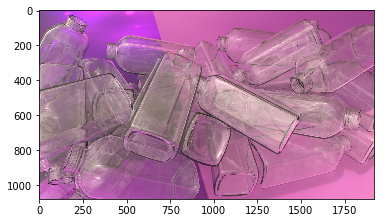

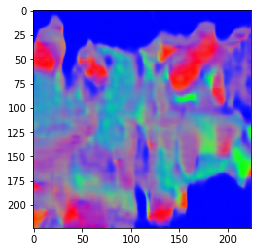

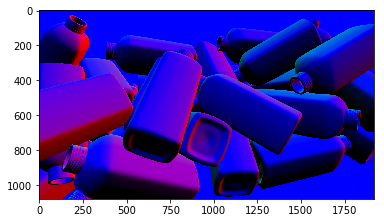

In [9]:
%matplotlib inline

import sys, os
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import models.unet_normals as unet
import numpy as np
from data_loader import Dataset,Options

class OPT():
    def __init__(self):
        self.dataroot = './data/'
        self.file_list = './data/datalist'
        self.batchSize = 24
        self.shuffle = True
        self.phase = 'eval'
        self.num_epochs = 1000
        self.imsize = 224
        self.num_classes = int(3)
        self.gpu = '0'
        self.logs_path = 'logs/exp2'

opt = OPT()
dataloader = Dataset(opt)

device = torch.device("cuda:"+ opt.gpu if torch.cuda.is_available() else "cpu")

checkpoint_path = 'logs/exp2/checkpoints/checkpoint-ep_990-iter_1.pth'
img_path = 'data/000000011-rgb.jpg'
exr_ground_truth_path = 'data/000000011-normals.exr'

# Open and Transform Img
img_not_preprocessed = Image.open(img_path).convert("RGB")
img = dataloader.transformImage(img_not_preprocessed)
img = img.unsqueeze(0)

# Send img to device
img = Variable(img.to(device))

# Load Model
fcn = unet.Unet(num_classes=opt.num_classes)
fcn.load_state_dict(torch.load(checkpoint_path))
fcn.to(device)
fcn.eval()

# Inference
res = fcn(img)
res_norm = nn.functional.normalize(res, p=2, dim=1)
output = res_norm.squeeze(0)
output = output.data.cpu().numpy()
print('output.shape:')
print(output.shape)
 
# Display Results
# Orig image
plt.imshow(img_not_preprocessed)
plt.show()

# Output Normals visualized with RGB
camera_normal_rgb = dataloader.normals_to_rgb(output)
camera_normal_rgb = np.transpose(camera_normal_rgb, (1,2,0))
plt.imshow(camera_normal_rgb)
plt.show()

# Ground Truth Normals as RGB
truth_normal = dataloader.exr_loader(exr_ground_truth_path, ndim=3)
truth_normal_rgb = dataloader.normals_to_rgb(truth_normal)
truth_normal_rgb = np.transpose(truth_normal_rgb, (1,2,0))
plt.imshow(truth_normal_rgb)
plt.show()